<a href="https://colab.research.google.com/github/yamashitafumihiro/machine_learning/blob/visual/transfer_learning_penguins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!pip install icrawler

In [ ]:
from icrawler.builtin import BingImageCrawler

# マゼランペンギンの画像を100枚取得
# より多くの画像を取得するためと正確性のためにkeywordには学名を指定
crawler = BingImageCrawler(storage={"root_dir": "マゼランペンギン"})
crawler.crawl(keyword="Spheniscus magellanicus", max_num=1000)

ERROR:downloader:Response status code 403, file https://pics.davesgarden.com/pics/2018/04/17/Kell/debde8.jpg
ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Spheniscus_magellanicus_Oceanario.jpg
ERROR:downloader:Response status code 400, file https://img.pixers.pics/pho_wat(s3:700/FO/59/82/86/77/700_FO59828677_66f6bf836433734e0859e451df7d020f.jpg
ERROR:downloader:Response status code 404, file https://live.staticflickr.com/2407/2222742947_e9115b31cd_b.jpg
ERROR:downloader:Response status code 403, file https://pics.davesgarden.com/pics/2018/04/17/Kell/eb15ce.jpg


In [ ]:
!unzip penguins.zip

Archive:  penguins.zip
   creating: penguins/train/
   creating: penguins/train/humboldti/
  inflating: penguins/train/humboldti/1.humboldt_penguin_spheniscus_humboldti_newquay_zoo.jpg  
  inflating: penguins/train/humboldti/10.humboldt-penguin-cute-nature-zoo-spheniscus-humboldti-animal-bird-feathers-wildlife-portrait.jpg  
  inflating: penguins/train/humboldti/11.62140712.jpg  
  inflating: penguins/train/humboldti/12.900.jpg  
  inflating: penguins/train/humboldti/13.humboldt-penguin-spheniscus-humboldti-picture-id483573157.jpg  
  inflating: penguins/train/humboldti/14.68262120.jpg  
  inflating: penguins/train/humboldti/15.60217050.jpg  
  inflating: penguins/train/humboldti/16.depositphotos_10887130-stock-photo-humboldt-penguins-spheniscus-humboldti-standing.jpg  
  inflating: penguins/train/humboldti/17.2010_010_1966.jpg  
  inflating: penguins/train/humboldti/18.70792085.jpg  
  inflating: penguins/train/humboldti/19.depositphotos_146716193-stock-photo-humboldt-penguin-sphenisc

/content


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/penguins'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


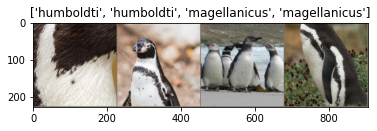

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8215 Acc: 0.5282
val Loss: 0.3988 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.8240 Acc: 0.7179
val Loss: 1.1744 Acc: 0.6500

Epoch 2/24
----------
train Loss: 0.8361 Acc: 0.6872
val Loss: 0.4115 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.5645 Acc: 0.7538
val Loss: 0.5167 Acc: 0.6500

Epoch 4/24
----------
train Loss: 0.5090 Acc: 0.7897
val Loss: 0.5348 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.5738 Acc: 0.7487
val Loss: 0.5935 Acc: 0.7500

Epoch 6/24
----------
train Loss: 0.7414 Acc: 0.7487
val Loss: 0.4899 Acc: 0.8000

Epoch 7/24
----------
train Loss: 0.4640 Acc: 0.8154
val Loss: 0.0878 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2574 Acc: 0.8769
val Loss: 0.1880 Acc: 0.8500

Epoch 9/24
----------
train Loss: 0.3723 Acc: 0.8513
val Loss: 0.1425 Acc: 0.8500

Epoch 10/24
----------
train Loss: 0.3648 Acc: 0.8615
val Loss: 0.1781 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.3980 Acc: 0.8513
val Loss: 0.2175 Acc: 0.8500

Epoch 12/24
----------
t

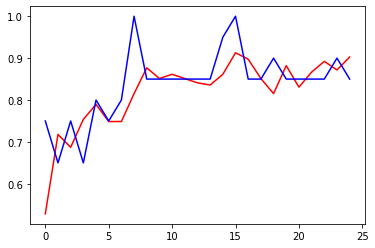

In [ ]:
import matplotlib.pyplot as plt

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
y1 = [0.5282,0.7179,0.6872,0.7538,0.7897,0.7487,0.7487,0.8154,0.8769,0.8513,0.8615,0.8513,0.8410,0.8359,0.8615,0.9128,0.8974,0.8513,0.8154,0.8821,0.8308,0.8667,0.8923,0.8718,0.9026]
y2 = [0.7500,0.6500,0.7500,0.6500,0.8000,0.7500,0.8000,1.0000,0.8500,0.8500,0.8500,0.8500,0.8500,0.8500,0.9500,1.0000,0.8500,0.8500,0.9000,0.8500,0.8500,0.8500,0.8500,0.9000,0.8500]
plt.plot(x, y1, color="red")
plt.plot(x, y2, color='blue');

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7323 Acc: 0.5538
val Loss: 0.5108 Acc: 0.8000

Epoch 1/24
----------
train Loss: 0.5948 Acc: 0.6718
val Loss: 0.8640 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.5481 Acc: 0.7128
val Loss: 0.5414 Acc: 0.6000

Epoch 3/24
----------
train Loss: 0.4686 Acc: 0.7846
val Loss: 0.4485 Acc: 0.6500

Epoch 4/24
----------
train Loss: 0.6645 Acc: 0.6667
val Loss: 0.3500 Acc: 0.9500

Epoch 5/24
----------
train Loss: 0.4933 Acc: 0.7897
val Loss: 0.2371 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.5197 Acc: 0.7949
val Loss: 0.2373 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.3592 Acc: 0.8410
val Loss: 0.2510 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4096 Acc: 0.8205
val Loss: 0.2698 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.4691 Acc: 0.7590
val Loss: 0.2443 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.4741 Acc: 0.7795
val Loss: 0.2386 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.4088 Acc: 0.8154
val Loss: 0.2454 Acc: 0.9000

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


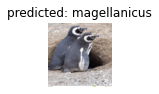

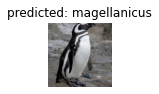

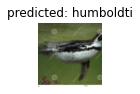

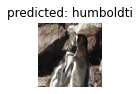

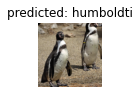

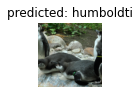

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [ ]:
from icrawler.builtin import BingImageCrawler
crawler = BingImageCrawler(storage={"root_dir": "magellanicus"})
crawler.crawl(keyword="spheniscus magellanicus", max_num=10)

2021-11-20 14:23:17,125 - INFO - icrawler.crawler - start crawling...
2021-11-20 14:23:17,127 - INFO - icrawler.crawler - starting 1 feeder threads...
2021-11-20 14:23:17,133 - INFO - feeder - thread feeder-001 exit
2021-11-20 14:23:17,134 - INFO - icrawler.crawler - starting 1 parser threads...
2021-11-20 14:23:17,141 - INFO - icrawler.crawler - starting 1 downloader threads...
2021-11-20 14:23:17,553 - INFO - parser - parsing result page https://www.bing.com/images/async?q=spheniscus magellanicus&first=0
2021-11-20 14:23:17,743 - INFO - downloader - image #1	https://birdscolombia.com/wp-content/uploads/2020/02/spheniscus-magellanicus.jpg
2021-11-20 14:23:17,919 - INFO - downloader - image #2	https://thumbs.dreamstime.com/b/magellanic-penguin-pair-spheniscus-magellanicus-magellanic-spheniscus-magellanicus-118058856.jpg
2021-11-20 14:23:18,216 - INFO - downloader - image #3	http://animais.culturamix.com/blog/wp-content/gallery/Spheniscus-Magellanicus-1/Spheniscus-Magellanicus-1.jpg
202

In [ ]:
!pip install icrawler